# Imports

In [214]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load Data

In [215]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Inspect Data

In [216]:
train.head()
train.describe()
train.info()
train.hist(bins=50, figsize=(20,15))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Only 1460 entries, but 81 features
\
A lot of NA values, in this data set NA represents something not being there e.g. no basement

In [217]:
corr_matrix = train.corr()
corr_matrix['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9693406dd0>,
      dtype=object)

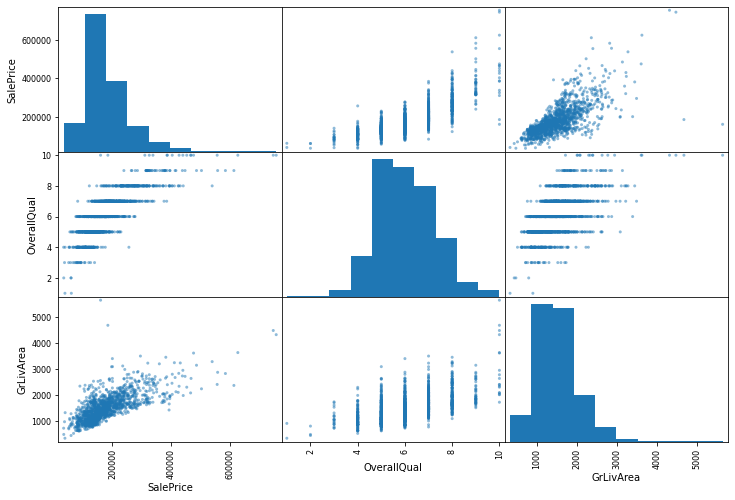

In [218]:
from pandas.plotting import scatter_matrix
attributes = ["SalePrice", "OverallQual", "GrLivArea"]
scatter_matrix(train[attributes], figsize=(12, 8))
# Find attributes most correlated to SalePrice and graph them

# Prepare Data

In [219]:
train_features = train.drop("SalePrice", axis=1)
train_labels = train['SalePrice'].copy()

train_features.fillna(0, inplace=True) # Replace NA values so they don't cause problems

In [220]:
from sklearn.preprocessing import OneHotEncoder
hot_encoder = OneHotEncoder()
cat_attribs = list(train_features.select_dtypes('object'))
# train_cat.replace(0, 'No Access', inplace=True)
# train_cat_encoded = hot_encoder.fit_transform(train_cat) # Turns categorical columns into binary (one attribute = 1 'hot' when true, rest 0 'cold)

In [221]:
from sklearn.preprocessing import StandardScaler
num_attribs = list(train_features.select_dtypes(exclude='object'))
# train_num.replace(0, None, inplace=True)
# train_num = StandardScaler().fit_transform(train_num) # Standardise numerical values

In [222]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Custom transformers and pipelines to speed up data manipulation in future
class ReplaceCat(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    X_ = X.copy()
    X_.replace(0, 'No Access', inplace=True)
    return X_

class ReplaceNum(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    X_ = X.copy()
    X_.replace(0, 0, inplace=True)
    return X_

num_pipeline = Pipeline([
 ('replacer', ReplaceNum()),
 ('std_scaler', StandardScaler()),
 ])

cat_pipeline = Pipeline([
 ('replacer', ReplaceCat()),
 ('encoder', OneHotEncoder(handle_unknown='ignore')),
 ])

full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", cat_pipeline, cat_attribs),
 ])

train_prepared = full_pipeline.fit_transform(train_features)

# Select and Train Model

In [223]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

lin_reg = LinearRegression()
lin_scores = cross_val_score(lin_reg, train_prepared, train_labels,
                             scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
print('Linear Regression RMSE:')
display_scores(lin_rmse_scores)

Linear Regression RMSE:
Scores: [ 23871.26505369  34696.85609703  23532.89872242  41465.97832669
  30303.22442007  44228.21148632  24340.16417052  22766.0688742
  67084.48315927 106539.87257652]
Mean: 41882.90228867371
Standard deviation: 25182.114034881302


In [224]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_scores = cross_val_score(tree_reg, train_prepared, train_labels,
                              scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
print('Decision Tree RMSE:')
display_scores(tree_rmse_scores)

Decision Tree RMSE:
Scores: [37043.79986325 40271.27374904 36984.3529625  40887.93537545
 39055.10037605 35300.52789828 31859.24743659 36007.26707541
 72916.36347781 37097.07200599]
Mean: 40742.29402203751
Standard deviation: 11001.322094237667


In [225]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_scores = cross_val_score(forest_reg, train_prepared, train_labels,
                                scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)
print('Random Forest RMSE:')
display_scores(forest_rmse_scores)

Random Forest RMSE:
Scores: [26333.57227949 31992.70454299 31383.97083136 24171.03147551
 36260.79797106]
Mean: 30028.415420081834
Standard deviation: 4301.14791656529


In [226]:
# some examples of predicitons by random forest
some_data = train_features.iloc[:5]
some_labels = train_labels.iloc[:5]
forest = forest_reg.fit(train_prepared, train_labels)
print('Labels: ', list(some_labels))
print('Predictions: ', forest.predict(full_pipeline.transform(some_data)))

Labels:  [208500, 181500, 223500, 140000, 250000]
Predictions:  [208181.   175724.5  220904.85 162049.38 265822.86]


Random forest seems the most convincing, lowest RMSE and with the lowest standard deviation.

# Fine Tune Model

In [227]:
attribs = num_attribs + cat_attribs
sorted(zip(forest.feature_importances_, attribs), reverse=True)

[(0.56298603497155, 'OverallQual'),
 (0.11832208834449487, 'GrLivArea'),
 (0.04042062657456627, 'TotalBsmtSF'),
 (0.032023210298676136, '2ndFlrSF'),
 (0.03158250838043434, 'GarageCars'),
 (0.03130234083871334, 'BsmtFinSF1'),
 (0.019177056974368705, '1stFlrSF'),
 (0.012903938827870994, 'LotArea'),
 (0.01135006317611803, 'GarageArea'),
 (0.009719055044710215, 'YearBuilt'),
 (0.005850815660097377, 'YearRemodAdd'),
 (0.005741306472160132, 'GarageYrBlt'),
 (0.005721059784079861, 'BsmtUnfSF'),
 (0.005572485331088409, 'FullBath'),
 (0.005396619050736935, 'MasVnrArea'),
 (0.005141276182690765, 'OpenPorchSF'),
 (0.004658701491805161, 'LotFrontage'),
 (0.0046538745096185614, 'TotRmsAbvGrd'),
 (0.0043432111366291755, 'WoodDeckSF'),
 (0.0042250419616788205, 'Id'),
 (0.003998704917399657, 'OverallCond'),
 (0.0033204117979866274, 'MoSold'),
 (0.0017029815120291121, 'BedroomAbvGr'),
 (0.0016686099247663158, 'LandContour'),
 (0.0016401220584727574, 'MSSubClass'),
 (0.001484408909550382, 'Fireplaces'),

Tells us the Random Forest thinks Overall Quality is the most important factor and Fence the least important, can inform us on any features we may want to drop.

In [228]:
from sklearn.model_selection import GridSearchCV

# Use cross validation to find best parameters for Forest
param_grid = [
 {'n_estimators': [100, 500], 'max_features': [20, 40, 60]},
 {'bootstrap': [False], 'n_estimators': [100, 500], 'max_features': [20, 40, 60]},
 ]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(train_prepared, train_labels)
grid_search.best_params_

# Gives bootstrap false max_features = 60 n_estimators = 500

# Final Model and Predictions

In [229]:
final_model = grid_search.best_estimator_
# final_model = RandomForestRegressor(bootstrap=False, max_features=60,n_estimators=500) # use for faster computation as these are best parameters found
final_model.fit(train_prepared, train_labels)
test_set = test.copy()
test_set.fillna(0, inplace=True)

In [230]:
test_prepared = full_pipeline.transform(test_set)
final_predictions = final_model.predict(test_prepared)

Below is just to save Dataframe in format ready for Kaggle submission

In [255]:
final = pd.DataFrame(final_predictions)
final.insert(0, 'Id', [x for x in range(1461, 2920)])
final.to_csv('Sale Price Predictions.csv', index=False) 

Final Score of 0.14116 on Kaggle.